In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
df = pd.read_csv('brisbane_water_quality.csv')

# Display basic info
print(df.info())
print(df.describe())
print(df.head())

# Drop missing values (you can choose imputation instead if needed)
df = df.dropna()

# Select only numerical columns for anomaly detection
df_num = df.select_dtypes(include=[np.number])

# Z-score Normalization
from scipy.stats import zscore

df_z = df_num.apply(zscore)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30894 entries, 0 to 30893
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   Timestamp                                 30894 non-null  object 
 1   Record number                             30894 non-null  int64  
 2   Average Water Speed                       30874 non-null  float64
 3   Average Water Direction                   30893 non-null  float64
 4   Chlorophyll                               30309 non-null  float64
 5   Chlorophyll [quality]                     30086 non-null  float64
 6   Temperature                               25730 non-null  float64
 7   Temperature [quality]                     25550 non-null  float64
 8   Dissolved Oxygen                          26594 non-null  float64
 9   Dissolved Oxygen [quality]                26370 non-null  float64
 10  Dissolved Oxygen (%Saturation)    

c:\Users\rayya\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
c:\Users\rayya\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
c:\Users\rayya\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\apply.py:1081: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  results[i] = self.func(v, *self.args, **self.kwargs)
c:\Users\rayya\AppData

In [3]:
from scipy.stats import zscore

# Remove columns with near-zero variance (constant or almost constant values)
low_variance_cols = df_num.loc[:, df_num.std() < 1e-5].columns
print(f"Low variance columns removed: {list(low_variance_cols)}")

df_num_filtered = df_num.drop(columns=low_variance_cols)

# Apply Z-score normalization safely
df_z = df_num_filtered.apply(zscore)


Low variance columns removed: ['Chlorophyll [quality]', 'Temperature [quality]', 'pH [quality]', 'Salinity [quality]', 'Specific Conductance [quality]', 'Turbidity [quality]']


In [6]:
from scipy.spatial.distance import mahalanobis

print("\n[Mahalanobis Distance] Calculating...")

# Step 1: Mean vector and covariance matrix
mean_vec = df_num_filtered.mean().values
cov_matrix = np.cov(df_num_filtered.values, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)  # Use pseudo-inverse for numerical stability

# Step 2: Compute Mahalanobis distance for each row
m_dist = [mahalanobis(x, mean_vec, inv_cov_matrix) for x in df_num_filtered.values]
df['Mahalanobis'] = m_dist

# Step 3: Define threshold at 95th percentile
m_threshold = np.percentile(m_dist, 95)
df['Mahalanobis_outlier'] = df['Mahalanobis'] > m_threshold

# Step 4: Print summary
print(f"Mahalanobis threshold (95th percentile): {m_threshold:.2f}")
print(f"Total outliers detected by Mahalanobis Distance: {df['Mahalanobis_outlier'].sum()} out of {len(df)} rows")



[Mahalanobis Distance] Calculating...
Mahalanobis threshold (95th percentile): 5.07
Total outliers detected by Mahalanobis Distance: 958 out of 19149 rows


In [7]:
from sklearn.neighbors import LocalOutlierFactor

print("\n[Local Outlier Factor] Detecting anomalies...")

# Step 1: Fit LOF model and predict
lof = LocalOutlierFactor(n_neighbors=20)
df['LOF'] = lof.fit_predict(df_z)
df['LOF_outlier'] = df['LOF'] == -1

# Step 2: Print summary
lof_outliers = df['LOF_outlier'].sum()
print(f"Total outliers detected by Local Outlier Factor: {lof_outliers} out of {len(df)} rows")



[Local Outlier Factor] Detecting anomalies...
Total outliers detected by Local Outlier Factor: 152 out of 19149 rows


In [8]:
from sklearn.ensemble import IsolationForest

print("\n[Isolation Forest] Detecting anomalies...")

# Step 1: Fit Isolation Forest model
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df['IF'] = iso_forest.fit_predict(df_z)
df['IF_outlier'] = df['IF'] == -1

# Step 2: Print summary
if_outliers = df['IF_outlier'].sum()
print(f"Total outliers detected by Isolation Forest: {if_outliers} out of {len(df)} rows")



[Isolation Forest] Detecting anomalies...
Total outliers detected by Isolation Forest: 958 out of 19149 rows


In [9]:
from sklearn.svm import OneClassSVM

print("\n[One-Class SVM] Detecting anomalies...")

# Step 1: Fit One-Class SVM model
ocsvm = OneClassSVM(nu=0.05, kernel='rbf', gamma='scale')
df['SVM'] = ocsvm.fit_predict(df_z)
df['SVM_outlier'] = df['SVM'] == -1

# Step 2: Print summary
svm_outliers = df['SVM_outlier'].sum()
print(f"Total outliers detected by One-Class SVM: {svm_outliers} out of {len(df)} rows")



[One-Class SVM] Detecting anomalies...
Total outliers detected by One-Class SVM: 955 out of 19149 rows


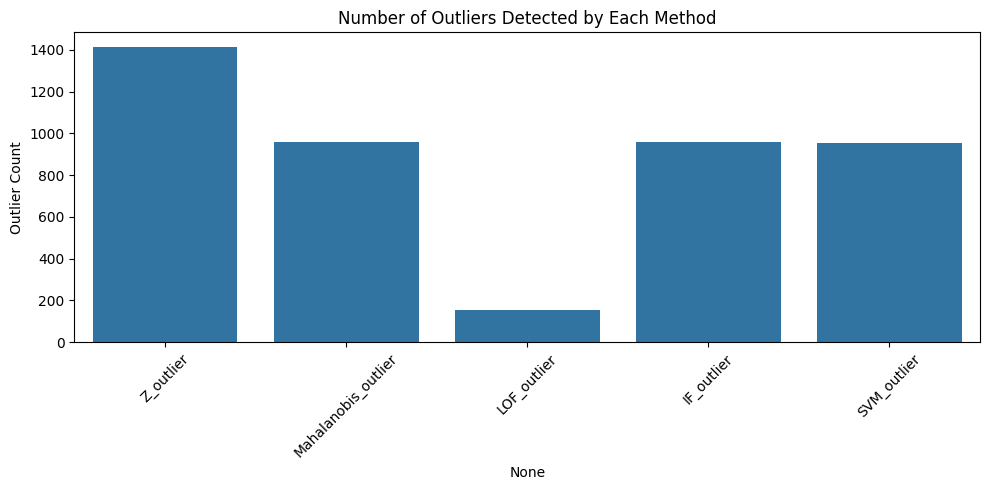

In [10]:
methods = ['Z_outlier', 'Mahalanobis_outlier', 'LOF_outlier', 'IF_outlier', 'SVM_outlier']
outlier_counts = df[methods].sum()

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.barplot(x=outlier_counts.index, y=outlier_counts.values)
plt.title("Number of Outliers Detected by Each Method")
plt.ylabel("Outlier Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


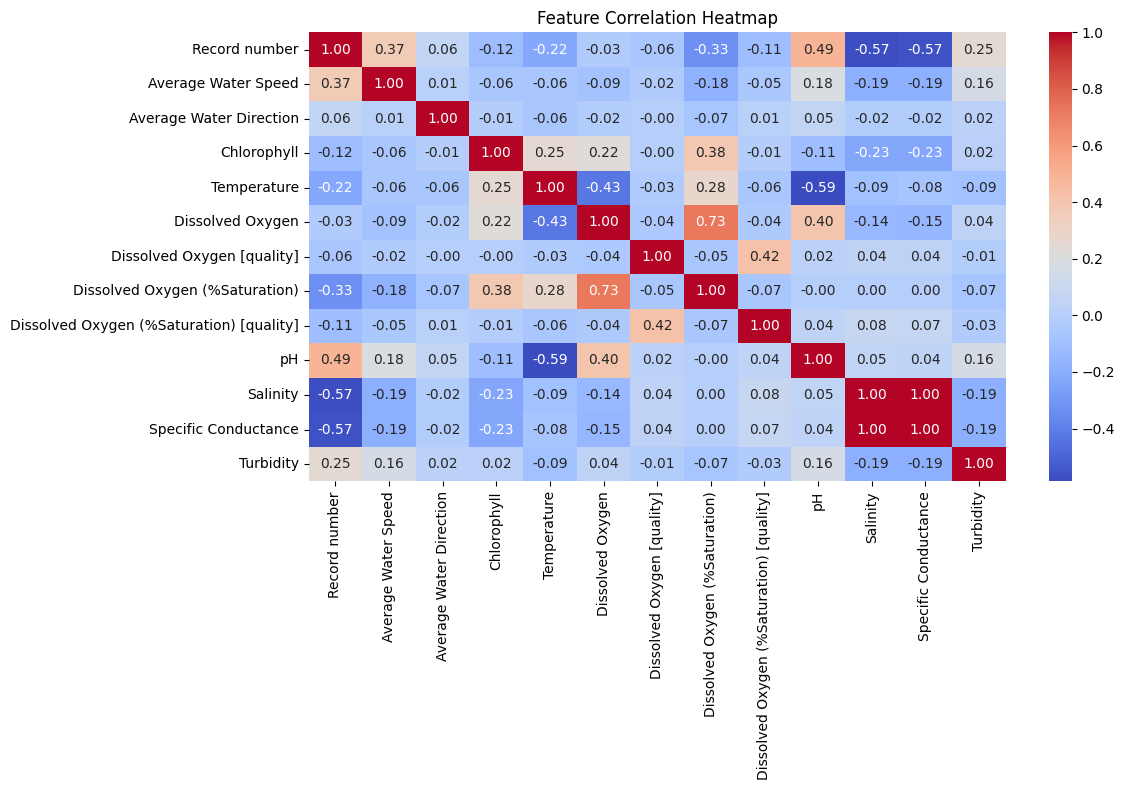

In [12]:
plt.figure(figsize=(12, 8))
sns.heatmap(df_num_filtered.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


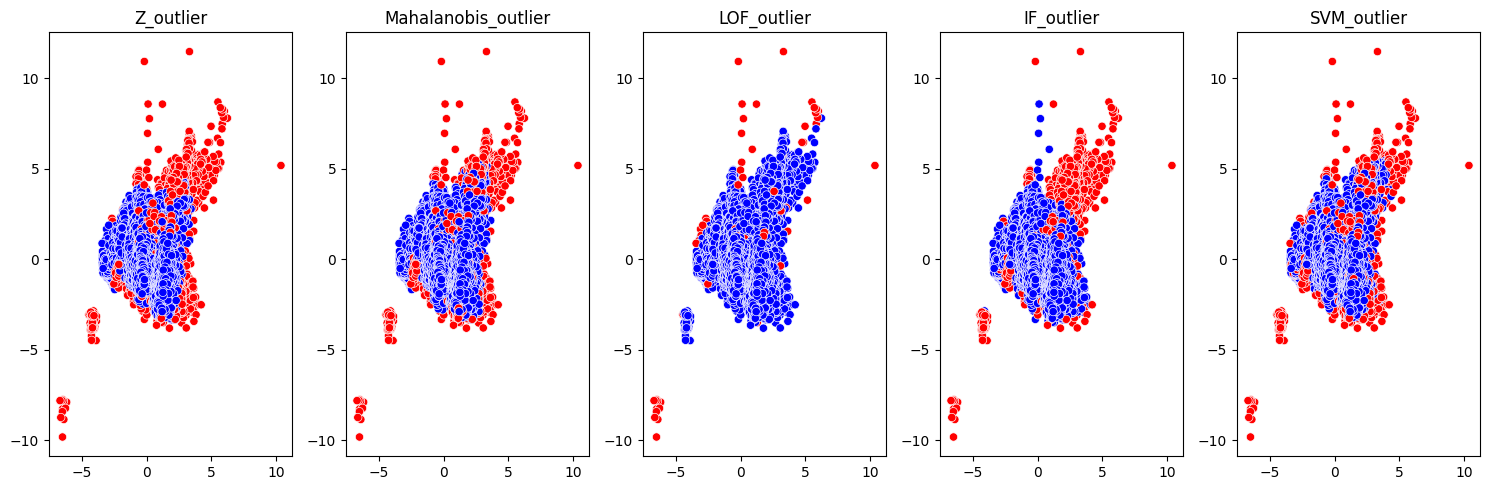

In [13]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca_data = pca.fit_transform(df_z)

plt.figure(figsize=(15, 5))
for i, method in enumerate(methods, 1):
    plt.subplot(1, 5, i)
    sns.scatterplot(x=pca_data[:, 0], y=pca_data[:, 1], hue=df[method], palette={False: "blue", True: "red"}, legend=False)
    plt.title(method)
plt.tight_layout()
plt.show()
